In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import lru_cache
import pickle
import os
import time
from matplotlib import image

In [3]:
# lines100 = []; 
# with open("linePoints" + str(100) + "_" + str(500) + ".pickle", "rb") as f:
#       lines100 = pickle.load(f); 
lines151 = []; 
with open("linePoints" + str(151) + "_" + str(500) + ".pickle", "rb") as f:
      lines151 = pickle.load(f); 

linesImg = [];

In [109]:
class StringArt:
    
    def __init__(self, DrawImg = None, radius = None, points = 50, imgSize = (200,200), grayFactor = 0.5, width = 1, useLines = None):
        self.fig, self.ax = plt.subplots(figsize=(10,10)); 
        self.size = imgSize; self.lineWidth = width; 
        self.drawImgName = DrawImg; 
        self.goalImg = image.imread(DrawImg); self.processDrawImg(); 
        self.img = np.zeros(imgSize); #okay atleast the image is a numpy array.
        self.center = (imgSize[0]/2, imgSize[1]/2); 
        self.joins = set(); #contains all the joins.
        self.nPoints = points; 
        self.grayFactor = grayFactor;
        self.gap = 2*np.pi/points;
        self.linePoints = [];
        for i in range(points):
            self.linePoints.append([0 for i in range(points)]); #an empty vector. each of them. n^2. 
        if radius == None:
            radius = imgSize[0]/2.05; 
        self.radius = radius; 
        self.allJoins = []; 
        for i in range(0,points): 
            self.allJoins.append(set());
        self.points = [];
        for i in range(points):
            self.points.append((self.center[0] + self.radius*np.cos(i*self.gap), self.center[1] + self.radius*np.sin(i*self.gap))); 
        if(not os.path.exists("linePoints" + str(points) + "_" + str(imgSize[0]) + ".pickle")):
            for i in range(points):
                for j in range(i+1, points):
                    self.getLinePointsBetween(i,j); #this saves the line points, which we can then pickle.
            with open("linePoints" + str(points) + "_" + str(imgSize[0]) + ".pickle", "wb") as f:
                pickle.dump(self.linePoints, f, protocol=pickle.HIGHEST_PROTOCOL);
        elif points != 151 or imgSize[0] != 500:
            with open("linePoints" + str(points) + "_" + str(imgSize[0]) + ".pickle", "rb") as f:
                self.linePoints = pickle.load(f);
        else:
            self.linePoints = lines151;
        self.last = 0;
        if(useLines != None):
            cnt = 0;
            for (i,j) in useLines:
                self.drawLineBetween(i,j); #just draw lines between em.
                cnt += 1;
                self.last = j;
                if(cnt % 100 == 0):
                    print("drew " + str(cnt) + "precalculated lines"); 

    def getLinePointsBetween(self, point0:int, point1:int, width = 5):
        if(type(self.linePoints[point0][point1]) == np.ndarray): return self.linePoints[point0][point1]; #memoisation.
        if(type(self.linePoints[point1][point0]) == np.ndarray): return self.linePoints[point1][point0]; 
        points0 = self.points[point0];
        points1 = self.points[point1]; 
        l = []
        offset = width;
        for i in range(int(max(min(points0[0] - offset, points1[0] - offset), 0)), int(min(max(points0[0] + offset, points1[0] + offset), self.size[1]))):
            for j in range(int(max(min(points0[1]-offset, points1[1]-offset),0)),int(min(max(points0[1]+offset, points1[1]+offset) , self.size[1]))+1):
                if(i >= self.size[0] or i < 0 or j < 0 or j >= self.size[1]):
                    continue; 
                dist = abs(self.getLineDistance(points0, points1, (i,j)));
                if(dist <= width):
                    l.append((i,j,dist)); 
        numpyArray = np.array(l); 
        if(point0 > point1):
            temp = point0; point0 = point1; point1 = temp;
        self.linePoints[point0][point1] = numpyArray;
        return l;

    def drawLineBetween(self, point0, point1):
        width = self.lineWidth; 
        for (i,j,d) in self.getLinePointsBetween(point0, point1, width):
            if(d < width):
                i = int(i); j = int(j); 
                self.img[i][j] += self.grayFactor*self.DistFunc(d, 0,width, 2);
                self.img[i][j] = min(self.img[i][j], 1); #to not go over 1.
        #will draw a straight line between these 2 points. how should we do it though.
    
    def getLineEquation(self, point0, point1):
        #return the line equation between these 2 points. 
        #y = mx + b
        #m = (y1 - y0)/(x1 - x0)
        #b = y0 - mx0
        m = (point1[1] - point0[1])/(point1[0] - point0[0]);
        b = point0[1] - m*point0[0];
        return (m,b);

    def getLineDistance(self, point0, point1, point2):
        #return the distance between point2 and the line between point0 and point1
        #d = |ax0 + by0 + c|/sqrt(a^2 + b^2)
        #a = y1 - y0
        #b = x0 - x1
        #c = x1y0 - x0y1
        a = point1[1] - point0[1]; 
        b = point0[0] - point1[0]; 
        c = point1[0]*point0[1] - point0[0]*point1[1];
        return abs(a*point2[0] + b*point2[1] + c)/np.sqrt(a**2 + b**2); 

    def DistFunc(self,point0, point1, width = None, pow = 1):
        if(width == None): width = self.lineWidth; 
        return (1 - abs(point0 - point1)/width)**(pow);

    def drawCircle(self, width = 5, radius = None, center = None, img = None):
        if(img == None):
            img = self.img;
        if(center == None):
            center = self.center;
        if(radius == None):
            radius = self.radius;
        outer = (radius + width)**2;
        inner = (radius - width)**2; 
        rsquare = radius**2;
        for i in range(0, img.shape[0]):
            for j in range(0, img.shape[1]):
                dist = (i - center[0])**2 + (j - center[1])**2;
                if inner <= dist <= outer:
                    img[i][j] += self.grayFactor*3*self.DistFunc(np.sqrt(dist), radius, width,2); #abs(np.sqrt(dist) - radius)/(width); 
        return img

    def showImage(self):
        #self.fig.savefig("Outputs/" + self.drawImgName[:-4] + "Stringed.png"); 
        self.ax.imshow(self.invertImage(self.img), cmap='gray', vmin=0, vmax=1);
        plt.show(); 
        # self.ax.clear();
        # self.ax.imshow(self.invertImage(self.goalImg), cmap='gray', vmin=0, vmax=1); 
        # plt.show();
    def invertImage(self,image):
        return 1-image; 
    def processDrawImg(self): 
        im = self.goalImg; 
        if(im.shape[2] != 3):
             im = im[:,:,0:3]; #remove the alpha channel
        im = [1., 1., 1.] - im; #to convert from 0 = black to 0 = white.
        #then we need to convert this to grayscale. the best way to do that would be to take the intensities and get the total mod of them.
        jm = np.zeros(shape=(im.shape[0], im.shape[1])); 
        for i in range(im.shape[0]):
            for j in range(im.shape[1]):
                jm[i][j] = np.sqrt(im[i][j][0]**2 + im[i][j][1]**2 + im[i][j][2]**2); 
        self.goalImg = jm; 
    def StartStringArt(self, totalStrings = 500, every = 10,curpoint = 0):
        #we will start with the first point and then choose the next point to draw a line to.
        #we will do this until we have drawn a line to every point.
        startTime = time.time();
        curPoint = self.last; 
        prevPoint = -1; 
        for i in range(0, totalStrings):
            (nextPoint, loss) = self.chooseNextPoint(curPoint, prevPoint); 
            # if(loss < 0):
            self.drawLineBetween(curPoint, nextPoint); 
            # else:
            #     print("skipped ", curPoint);
            #     curPoint = (curPoint + 1)%self.nPoints; 
            #     continue;
            linesImg.append((curPoint, nextPoint)); #add the line to the list of lines.
            prevPoint = curPoint;            
            curPoint = nextPoint;
            #curPoint = (curPoint + 1)%self.nPoints; 
            if(i%every == 0):
                print("Line ", i, " out of ", totalStrings, " done. Loss: ", loss); 
                
        self.showImage(); 
        plt.show();
    def chooseNextPoint(self, curPoint, prev = -1):
        #given the current point, choose the next point to draw a line to.
        #we will choose the point that will give us the least loss.
        curLoss = 100000; curNext = 0; #no next point so far.
        for i in range(0, self.nPoints):
            if(i == curPoint): # or i in self.allJoins[curPoint]): #if we have already made a line to this point, then we skip it, although perhaps we should allow making multiple lines I believe.
                continue; 
            ls = self.loss(curPoint, i);  
            if(ls < curLoss):
                curLoss = ls; 
                curNext = i; 
        if(prev == curNext and curLoss >= 0):
            curNext = (curPoint + 1)%(self.nPoints); 
        return (curNext, curLoss); #should form a join with this point next.

    #now then let us create a loss function for ourselves. this loss function will be used to determine which lines to draw.
    #we will use the following loss function:
    #the reward should be how much closer we get to the goal image. maybe need to experiment on the reward functions that are possibel
    def loss(self, point0, point1):
        #for the line between point0 and point1, what is the reward that we will get?.
        #maybe we can sum up all the different differences in the line and define that as the reward or perhaps its square.
        cost = 0; # should try to minimise the cost, or maximise ther reward.
        width = self.lineWidth;
        for (i,j,d) in self.getLinePointsBetween(point0, point1, width):
            if(d < width):
                i = int(i); j = int(j); 
                newVal = min(self.img[i][j] + self.grayFactor*self.DistFunc(d, 0,width, 2), 1); 
                cost += (newVal - self.goalImg[i][j])**5 - (self.img[i][j] - self.goalImg[i][j])**5; #this is the new cost.
        return cost; 


drew 100precalculated lines
drew 200precalculated lines
drew 300precalculated lines
drew 400precalculated lines
drew 500precalculated lines
drew 600precalculated lines
drew 700precalculated lines
drew 800precalculated lines
drew 900precalculated lines
drew 1000precalculated lines
drew 1100precalculated lines
drew 1200precalculated lines
drew 1300precalculated lines
drew 1400precalculated lines
drew 1500precalculated lines
drew 1600precalculated lines
drew 1700precalculated lines
drew 1800precalculated lines
drew 1900precalculated lines
drew 2000precalculated lines
drew 2100precalculated lines
drew 2200precalculated lines
drew 2300precalculated lines
drew 2400precalculated lines
drew 2500precalculated lines
drew 2600precalculated lines
drew 2700precalculated lines
drew 2800precalculated lines
drew 2900precalculated lines
drew 3000precalculated lines
drew 3100precalculated lines
drew 3200precalculated lines
drew 3300precalculated lines
drew 3400precalculated lines
drew 3500precalculated 

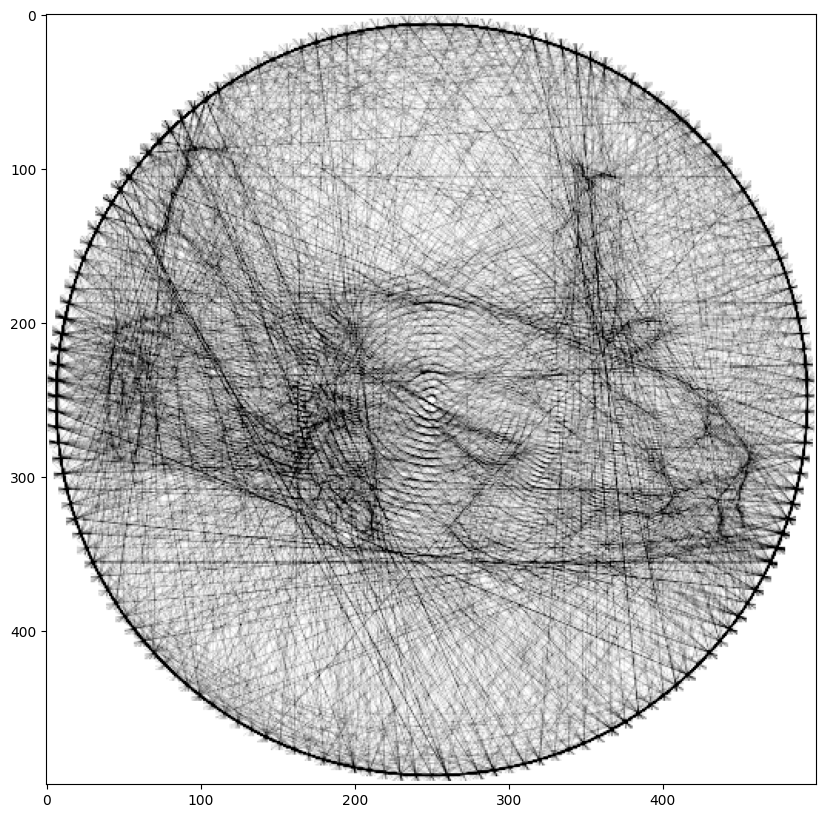

In [112]:
#now we need to make a circular image in plt.
n = 151; #tbh I think I should probably try with a much larger value, but that would definitely take a LOT of time.
SA = StringArt(points = n, DrawImg="GoalImages/goalAventador.png", imgSize=(500,500), grayFactor=0.12, useLines=linesImg);
SA.drawCircle(width=2)    
##linesImg = []; #this is the list of lines that we will be drawing.
SA.StartStringArt(totalStrings=10000, every = 50); 


In [261]:
with open("stormtrooper151Lines.pickle", "wb") as f:
    pickle.dump(lines151, f, protocol=pickle.HIGHEST_PROTOCOL);

730